# TESS Atlas fit for TOI 103

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 103.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-103.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-103.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-103.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 103

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 103 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

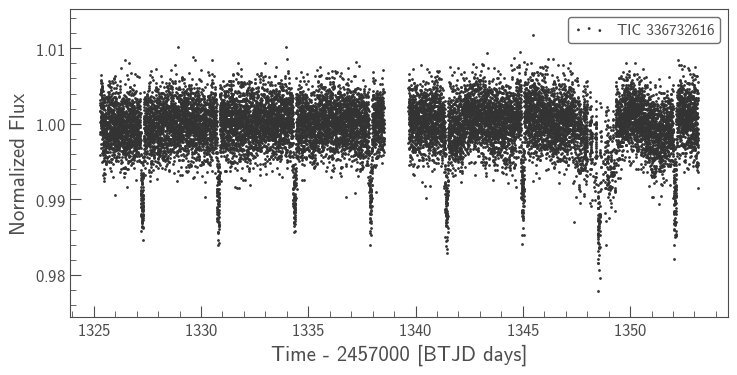

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -55588.35381448001 -> -55017.0219303136


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -43637.845922013665 -> -43627.533381976544


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -43627.533381976544 -> -43232.219076984555


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -43232.219076984555 -> -43125.778858217935


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -43125.778858217935 -> -43124.046357500585


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -43124.046357500585 -> -43119.93173550859


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -43119.93173550859 -> -43082.65277855802


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -43082.65277855803 -> -43082.65277855803


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -43082.65277855802 -> -43082.65277855802


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -43082.65277855802 -> -43082.65277855797


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -43082.65277855797 -> -43082.65277855797


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -43082.65277855797 -> -43082.65277855797


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -43082.65277855797 -> -43082.65277855797


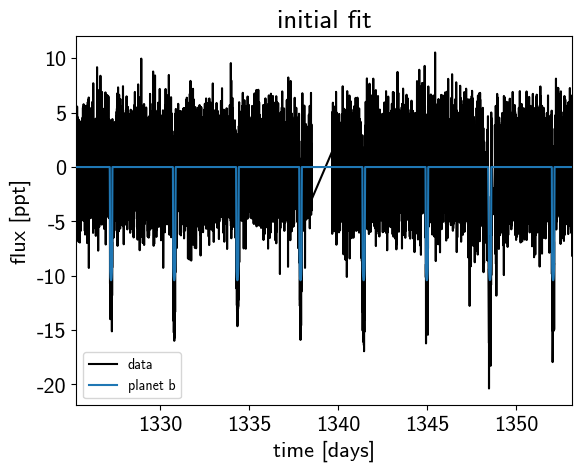

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:09,  9.54draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:18,  4.90draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:16,  5.51draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:29,  3.08draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:27,  3.31draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:34,  2.62draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:30,  2.84draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:36,  2.37draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:31,  2.71draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:37,  2.29draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:34,  2.46draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:34,  2.43draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:06<00:34,  2.40draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:30,  2.62draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:07<00:32,  2.43draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:29,  2.68draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:32,  2.43draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:08<00:27,  2.83draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:31,  2.45draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:29,  2.56draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:30,  2.46draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:28,  2.54draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:10<00:28,  2.52draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:28,  2.49draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:26,  2.61draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:11<00:27,  2.51draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:11<00:30,  2.20draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:12<00:29,  2.30draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:12<00:28,  2.29draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:13<00:25,  2.53draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:13<00:26,  2.38draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:13<00:23,  2.64draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:14<00:25,  2.43draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:14<00:21,  2.78draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:15<00:24,  2.46draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:15<00:21,  2.81draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:15<00:22,  2.58draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:16<00:19,  2.90draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:16<00:23,  2.36draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:16<00:20,  2.66draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:17<00:24,  2.19draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:17<00:18,  2.79draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:18<00:23,  2.22draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:18<00:21,  2.35draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:19<00:21,  2.28draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:19<00:21,  2.33draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:20<00:20,  2.29draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:20<00:21,  2.18draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:20<00:19,  2.38draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:21<00:18,  2.39draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:21<00:18,  2.39draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:22<00:16,  2.56draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:22<00:18,  2.23draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:22<00:15,  2.71draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:23<00:17,  2.29draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:23<00:14,  2.72draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:24<00:16,  2.30draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:24<00:14,  2.57draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:25<00:17,  2.08draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:25<00:12,  2.72draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:25<00:15,  2.17draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:26<00:14,  2.25draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:26<00:11,  2.78draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:27<00:13,  2.27draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:27<00:10,  2.68draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:28<00:11,  2.37draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:28<00:10,  2.54draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:29<00:11,  2.17draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:29<00:10,  2.37draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:30<00:10,  2.21draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:30<00:09,  2.54draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:31<00:11,  1.96draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:32<00:09,  2.07draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:32<00:08,  2.17draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:33<00:07,  2.15draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:34<00:06,  2.22draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:34<00:05,  2.48draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:35<00:05,  2.17draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:35<00:04,  2.29draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:36<00:04,  2.18draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:36<00:04,  2.22draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:37<00:03,  2.31draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:37<00:03,  1.99draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:38<00:02,  2.44draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:38<00:02,  1.89draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:39<00:01,  2.06draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:39<00:00,  2.48draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:42<00:01,  1.16s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:43<00:00,  1.06draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 12.06draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:08, 10.45draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:24,  3.74draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:21,  4.23draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:30,  2.90draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:27,  3.19draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:31,  2.74draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:26,  3.23draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.69draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:30,  2.75draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:25,  3.26draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:31,  2.57draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:29,  2.73draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:31,  2.58draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:30,  2.56draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:30,  2.59draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:26,  2.88draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:23,  3.26draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:32,  2.24draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:25,  2.91draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:32,  2.24draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:26,  2.68draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:30,  2.29draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:24,  2.80draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:31,  2.19draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:29,  2.25draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:24,  2.66draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:11<00:27,  2.37draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:28,  2.21draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:25,  2.44draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:27,  2.24draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:24,  2.42draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:26,  2.20draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:24,  2.39draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:23,  2.43draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:21,  2.60draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:17,  3.02draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:17,  2.99draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:19,  2.71draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:15,  3.30draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:17<00:18,  2.64draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:17<00:16,  2.91draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:20,  2.33draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:15,  2.99draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:18<00:20,  2.24draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:19<00:15,  2.79draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:19<00:19,  2.20draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:14,  2.86draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:13,  2.90draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:20<00:11,  3.49draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:21<00:14,  2.54draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:11,  3.12draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:22<00:14,  2.41draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:10,  3.26draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:23<00:14,  2.26draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:13,  2.38draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:23<00:09,  3.15draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:11,  2.47draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:24<00:09,  2.77draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:25<00:10,  2.41draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:08,  2.78draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:26<00:08,  2.69draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:27<00:07,  2.66draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:07,  2.84draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:07,  2.59draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:28<00:07,  2.29draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:28<00:06,  2.74draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:29<00:07,  2.19draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:29<00:05,  2.80draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:30<00:04,  2.70draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:31<00:04,  2.69draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:31<00:03,  3.15draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:31<00:02,  3.33draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:32<00:02,  3.32draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:32<00:02,  2.89draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:32<00:01,  2.77draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:33<00:01,  2.70draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:34<00:01,  1.83draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:35<00:01,  1.51draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:36<00:00,  1.22draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:38<00:00,  1.23s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:39,  1.27draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<02:01,  1.66draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<01:32,  2.18draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:20,  2.48draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:20,  2.48draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:04,  3.05draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:06,  2.95draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:12,  2.69draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:13,  2.63draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:03,  3.02draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:08,  2.79draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<00:58,  3.23draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:05<01:09,  2.70draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:05<00:54,  3.43draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<00:56,  3.28draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:06<01:00,  3.08draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:18,  2.35draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:07<01:01,  2.98draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:07<00:51,  3.56draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<01:08,  2.63draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:08<01:13,  2.46draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:08<01:06,  2.69draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:09<01:26,  2.07draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:09<01:06,  2.64draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:10<01:17,  2.24draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:10<01:10,  2.48draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:11<01:17,  2.22draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:11<01:10,  2.45draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:11<01:00,  2.82draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:12<00:47,  3.58draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:12<00:39,  4.26draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:12<00:53,  3.14draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:13<00:56,  2.93draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:13<00:57,  2.84draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:13<00:45,  3.58draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:14<01:06,  2.45draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:14<00:48,  3.30draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:14<00:38,  4.10draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:15<00:36,  4.36draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:15<00:37,  4.19draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:15<00:39,  3.89draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:16<00:32,  4.74draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:16<00:25,  6.02draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:16<00:21,  7.11draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:16<00:23,  6.28draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:17<00:32,  4.47draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:17<00:41,  3.55draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:17<00:40,  3.60draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:18<00:46,  3.10draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:19<00:51,  2.78draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:19<00:40,  3.49draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:19<00:40,  3.43draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:19<00:34,  4.03draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:20<00:29,  4.66draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:20<00:48,  2.77draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:20<00:41,  3.19draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:21<00:39,  3.36draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:22<00:40,  3.17draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:22<00:34,  3.76draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:22<00:34,  3.66draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:22<00:29,  4.34draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:23<00:34,  3.67draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:23<00:39,  3.14draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:24<00:48,  2.54draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:24<00:47,  2.60draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:24<00:49,  2.47draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:25<00:46,  2.62draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:25<00:50,  2.38draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:26<00:48,  2.45draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:26<00:37,  3.14draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:26<00:30,  3.78draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:26<00:27,  4.21draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:27<00:43,  2.57draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:27<00:34,  3.26draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:27<00:32,  3.46draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:28<00:30,  3.63draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:28<00:27,  3.91draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:28<00:21,  4.88draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:28<00:22,  4.62draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:29<00:35,  2.97draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:30<00:36,  2.82draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:30<00:29,  3.46draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:30<00:38,  2.64draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:31<00:32,  3.04draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:31<00:32,  3.05draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:31<00:27,  3.53draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:31<00:25,  3.78draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:32<00:21,  4.56draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:32<00:19,  4.96draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:32<00:22,  4.12draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:32<00:18,  4.98draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:32<00:17,  5.29draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:32<00:15,  5.97draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:33<00:20,  4.43draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:33<00:21,  4.14draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:33<00:17,  5.02draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:33<00:16,  5.14draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:34<00:16,  5.08draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:34<00:18,  4.51draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:34<00:20,  4.02draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:34<00:17,  4.82draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:35<00:18,  4.39draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:35<00:15,  5.20draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:35<00:13,  6.04draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:35<00:15,  4.91draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:36<00:13,  5.49draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:36<00:17,  4.17draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:36<00:14,  5.05draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:37<00:15,  4.37draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:38<00:19,  3.39draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:39<00:18,  3.50draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:40<00:16,  3.74draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:40<00:18,  3.35draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:40<00:15,  3.97draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:40<00:13,  4.33draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:40<00:11,  4.85draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:41<00:10,  5.44draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:41<00:07,  6.94draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:41<00:06,  8.16draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:41<00:08,  6.17draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:42<00:11,  4.43draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:42<00:14,  3.37draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:43<00:14,  3.32draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:43<00:10,  4.21draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:43<00:09,  4.79draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:44<00:14,  2.98draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:44<00:14,  2.91draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:44<00:10,  3.82draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:45<00:13,  2.87draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:45<00:12,  3.00draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:45<00:10,  3.52draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:46<00:08,  3.93draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:46<00:10,  3.12draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:46<00:09,  3.45draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:47<00:08,  3.66draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:47<00:08,  3.84draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:47<00:11,  2.57draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:48<00:08,  3.26draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:48<00:08,  3.43draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:48<00:09,  2.98draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:49<00:09,  2.81draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:49<00:06,  3.56draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:50<00:06,  3.11draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:51<00:09,  2.18draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:52<00:08,  2.14draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:52<00:06,  2.53draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:52<00:05,  2.82draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:53<00:05,  2.50draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:53<00:05,  2.41draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:54<00:06,  1.91draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:54<00:04,  2.25draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:55<00:04,  2.19draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:56<00:05,  1.78draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:56<00:05,  1.57draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:57<00:04,  1.43draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:58<00:04,  1.31draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:59<00:03,  1.36draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:00<00:01,  1.56draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:00<00:01,  1.72draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:01<00:00,  1.53draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:01<00:00,  3.32draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:18, 21.20draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:18, 21.57draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:21, 18.70draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:22, 17.17draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:24, 15.97draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:24, 15.95draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:22, 17.26draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:19, 20.07draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:16, 22.68draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:15, 24.51draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:16, 21.93draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:16, 22.47draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:01<00:14, 24.52draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:15, 23.95draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:02<00:14, 23.82draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:02<00:14, 24.35draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:02<00:17, 20.15draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:02<00:19, 17.69draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:02<00:19, 17.95draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:02<00:16, 20.28draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:02<00:14, 23.74draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:03<00:12, 26.58draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:13, 24.38draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:03<00:14, 22.47draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:03<00:13, 23.64draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:03<00:12, 25.20draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:03<00:12, 26.22draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:04<00:10, 28.47draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:04<00:10, 29.46draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:04<00:09, 30.81draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:04<00:10, 29.21draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:04<00:14, 20.87draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:04<00:14, 19.81draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:05<00:14, 19.70draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:05<00:16, 17.47draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:05<00:14, 19.96draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:05<00:12, 22.99draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:05<00:12, 22.77draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:05<00:13, 19.54draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:05<00:12, 22.37draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:06<00:10, 24.42draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:06<00:11, 23.03draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:06<00:11, 22.06draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:06<00:11, 22.85draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:06<00:10, 24.67draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:06<00:11, 21.58draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:07<00:13, 17.80draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:07<00:12, 19.55draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:07<00:12, 19.75draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:07<00:11, 21.37draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:07<00:10, 21.38draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:07<00:10, 21.96draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:07<00:10, 21.33draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:07<00:10, 22.19draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:08<00:09, 24.10draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:08<00:07, 27.12draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:08<00:07, 27.62draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:08<00:07, 29.06draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:08<00:07, 28.02draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:08<00:06, 29.51draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:08<00:06, 31.50draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:08<00:05, 35.11draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:09<00:05, 32.30draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:09<00:06, 28.27draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:09<00:06, 27.88draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:09<00:06, 27.59draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:09<00:06, 28.30draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:09<00:07, 21.62draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:10<00:08, 20.07draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:10<00:08, 19.00draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:10<00:08, 18.39draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:10<00:08, 18.10draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:10<00:07, 20.85draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:10<00:06, 23.76draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:10<00:06, 21.80draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:11<00:06, 21.65draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:11<00:06, 22.38draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:11<00:06, 20.09draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:11<00:06, 21.43draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:11<00:05, 22.50draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:11<00:05, 21.78draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:11<00:05, 22.19draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:12<00:05, 23.42draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:12<00:04, 23.69draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:12<00:04, 24.84draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:12<00:04, 26.15draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:12<00:04, 24.35draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:12<00:04, 23.25draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:12<00:04, 23.28draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:12<00:03, 26.25draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:13<00:03, 27.13draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:13<00:03, 28.85draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:13<00:02, 30.40draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:13<00:02, 29.74draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:13<00:02, 30.87draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:13<00:02, 32.06draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:13<00:02, 32.60draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:13<00:02, 32.89draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:14<00:02, 27.33draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:14<00:02, 28.74draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:14<00:01, 29.35draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:14<00:02, 24.43draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:14<00:02, 22.44draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:15<00:02, 16.44draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:15<00:02, 15.01draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:15<00:03, 12.38draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:15<00:03, 11.73draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:15<00:03, 11.08draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:16<00:02, 12.67draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:16<00:02, 13.13draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:16<00:02, 14.07draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:16<00:01, 14.05draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:16<00:01, 13.87draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:16<00:01, 12.12draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:17<00:01, 11.65draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:17<00:01, 12.20draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:17<00:01, 13.66draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:17<00:00, 14.80draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:17<00:00, 12.56draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:17<00:00, 12.87draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:17<00:00, 14.16draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:18<00:00, 13.99draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:18<00:00, 15.09draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:18<00:00, 11.10draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:18<00:00, 10.40draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:30, 26.57draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:27, 29.34draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:25, 31.49draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:27, 29.14draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:00<00:37, 20.96draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:00<00:34, 22.84draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:00<00:32, 24.35draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:01<00:32, 23.98draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<00:29, 26.00draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:01<00:26, 29.27draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:26, 28.92draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:02<01:03, 11.88draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:02<00:58, 12.93draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:02<00:58, 12.81draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:02<00:52, 14.27draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:02<00:48, 15.51draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:03<00:53, 13.89draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:03<00:47, 15.59draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:03<00:48, 15.35draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:03<00:53, 13.74draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:03<01:08, 10.83draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:04<01:02, 11.75draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:04<01:05, 11.17draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:04<01:11, 10.27draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:04<00:58, 12.54draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:04<00:47, 15.32draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:04<00:40, 17.64draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:04<00:35, 20.03draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:05<00:30, 23.30draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:05<00:29, 24.30draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:05<00:25, 27.31draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:05<00:30, 23.16draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:05<00:28, 24.62draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:05<00:25, 27.61draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:05<00:22, 30.06draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:06<00:38, 17.67draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:06<00:39, 17.39draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:06<00:39, 17.07draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:06<00:46, 14.68draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:07<00:52, 12.86draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:07<00:51, 13.03draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:07<00:42, 15.58draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:07<00:39, 16.84draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:07<00:34, 19.01draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:07<00:31, 20.74draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:07<00:31, 21.12draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:08<00:26, 24.54draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:08<00:25, 25.60draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:08<00:38, 16.85draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:08<00:38, 16.85draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:08<00:34, 18.34draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:08<00:32, 19.59draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:09<00:30, 20.65draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:09<00:29, 21.43draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:09<00:28, 22.29draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:09<00:27, 22.83draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:09<00:27, 22.25draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:09<00:26, 23.24draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:09<00:25, 24.02draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [00:09<00:25, 24.36draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:10<00:25, 23.49draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:10<00:26, 22.91draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:10<00:24, 24.89draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:10<00:21, 27.97draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:10<00:21, 28.20draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:10<00:21, 27.95draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:10<00:17, 33.14draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:10<00:16, 34.51draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:11<00:15, 37.38draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:11<00:17, 33.37draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:11<00:20, 27.55draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:11<00:25, 22.17draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:11<00:29, 19.01draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:12<00:25, 22.04draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:12<00:21, 25.47draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:12<00:19, 28.23draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:12<00:19, 28.19draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:12<00:23, 22.96draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:12<00:21, 24.63draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [00:12<00:21, 25.02draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:13<00:22, 23.92draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:13<00:24, 21.81draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:13<00:22, 23.71draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:13<00:20, 25.86draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:13<00:18, 27.69draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:13<00:17, 29.16draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:13<00:17, 29.32draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:14<00:17, 28.74draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:14<00:17, 28.43draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:14<00:18, 27.43draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:14<00:16, 29.93draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:14<00:14, 32.28draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:14<00:13, 34.75draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:14<00:14, 32.75draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:14<00:14, 31.58draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:15<00:15, 29.80draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:15<00:17, 26.13draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:15<00:16, 27.41draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:15<00:17, 26.00draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:15<00:18, 24.47draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:15<00:18, 24.70draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:15<00:18, 23.54draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:16<00:18, 24.15draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:16<00:18, 23.20draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:16<00:18, 23.85draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:16<00:18, 23.87draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:16<00:17, 25.08draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:16<00:19, 22.19draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:16<00:18, 22.82draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:16<00:17, 23.57draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:17<00:17, 24.62draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:17<00:15, 26.82draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:17<00:14, 28.46draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:17<00:13, 31.05draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:17<00:11, 34.79draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:17<00:11, 35.13draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:17<00:11, 33.86draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:17<00:12, 30.49draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:18<00:13, 28.70draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:18<00:14, 26.30draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:18<00:14, 25.85draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:18<00:13, 28.83draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:18<00:14, 25.54draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:18<00:13, 27.05draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:18<00:12, 29.36draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:19<00:10, 33.15draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:19<00:10, 34.18draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:19<00:09, 34.93draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:19<00:10, 32.83draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:19<00:10, 31.63draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:19<00:10, 33.40draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:19<00:11, 28.13draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:20<00:12, 25.62draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:20<00:12, 26.39draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:20<00:12, 26.24draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:20<00:13, 22.84draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [00:20<00:12, 25.19draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:20<00:12, 25.67draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:20<00:12, 25.09draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:20<00:12, 25.14draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:21<00:10, 28.05draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:21<00:09, 32.15draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:21<00:08, 35.10draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:21<00:09, 30.33draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:21<00:09, 28.80draws/s]

Sampling 2 chains:  65%|██████▌   | 525/804 [00:21<00:10, 27.31draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:21<00:09, 28.87draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:22<00:09, 29.55draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:22<00:08, 29.69draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:22<00:09, 27.80draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:22<00:09, 28.19draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:22<00:09, 27.06draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:22<00:10, 24.37draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:22<00:10, 23.56draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:22<00:10, 24.38draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:23<00:10, 24.18draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:23<00:11, 21.97draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:23<00:10, 22.13draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:23<00:09, 23.86draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:23<00:09, 25.17draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:23<00:09, 23.70draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:23<00:09, 24.17draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:23<00:08, 25.55draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:24<00:07, 29.58draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:24<00:06, 34.47draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:24<00:06, 34.64draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:24<00:05, 34.74draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:24<00:06, 31.78draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:24<00:07, 27.66draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:24<00:06, 28.52draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:25<00:07, 25.85draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:25<00:06, 30.20draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:25<00:05, 32.51draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:25<00:05, 31.06draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:25<00:05, 33.47draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:25<00:04, 35.63draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:25<00:04, 35.87draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:25<00:04, 33.52draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:26<00:04, 33.15draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:26<00:04, 30.06draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:26<00:04, 30.11draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:26<00:04, 33.29draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:26<00:04, 28.36draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:26<00:04, 27.89draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:26<00:05, 24.83draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:27<00:05, 23.62draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:27<00:04, 26.87draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:27<00:04, 27.50draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:27<00:03, 30.18draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:27<00:03, 30.36draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:27<00:02, 34.60draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [00:27<00:02, 34.90draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:27<00:03, 29.84draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:28<00:02, 31.12draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [00:28<00:02, 30.33draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:28<00:02, 31.30draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:28<00:02, 31.88draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:28<00:02, 33.34draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:28<00:02, 32.25draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:28<00:02, 28.33draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:29<00:02, 25.62draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:29<00:02, 23.16draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [00:29<00:02, 22.83draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:29<00:02, 23.19draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:29<00:02, 18.84draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [00:29<00:02, 18.03draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [00:29<00:02, 19.17draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:30<00:02, 20.25draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:30<00:01, 20.60draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:30<00:01, 20.66draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:30<00:01, 19.24draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:30<00:01, 20.00draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:30<00:01, 20.47draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:30<00:01, 21.19draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:31<00:00, 22.26draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:31<00:00, 18.59draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:31<00:00, 19.40draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:31<00:00, 20.07draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:31<00:00, 20.66draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:31<00:00, 20.10draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:32<00:00, 20.24draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:32<00:00, 16.60draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<03:18, 22.12draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:48, 26.13draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<02:33, 28.68draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<02:33, 28.56draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<02:24, 30.38draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:00<02:15, 32.25draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:00<03:03, 23.87draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<03:10, 22.95draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<03:16, 22.28draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<04:15, 17.10draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:01<03:47, 19.20draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:01<03:50, 18.89draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<04:06, 17.64draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<04:29, 16.19draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<04:21, 16.62draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:02<04:05, 17.74draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:02<03:40, 19.75draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:02<03:18, 21.90draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:02<03:17, 21.94draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:02<03:02, 23.74draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:02<02:51, 25.22draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:03<02:58, 24.25draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:03<02:38, 27.34draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:03<02:47, 25.79draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:03<05:11, 13.86draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:03<04:51, 14.80draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:04<04:58, 14.44draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:04<04:21, 16.49draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:04<04:00, 17.93draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:04<03:47, 18.97draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:04<03:35, 19.93draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:04<03:16, 21.94draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:04<02:57, 24.26draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:05<02:40, 26.83draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:05<02:40, 26.69draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:05<02:23, 29.92draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:05<02:34, 27.65draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:05<02:44, 26.00draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:05<02:41, 26.51draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:05<02:20, 30.39draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:06<02:52, 24.76draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:06<03:01, 23.45draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:06<02:56, 24.18draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:06<02:59, 23.68draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:06<03:01, 23.44draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:06<02:54, 24.31draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:06<02:49, 25.12draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:06<02:31, 28.03draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:07<02:17, 30.80draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:07<02:02, 34.47draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:07<01:55, 36.59draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:07<02:22, 29.58draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:07<02:20, 30.03draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:07<02:48, 25.00draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:08<03:09, 22.19draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:08<02:49, 24.81draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:08<02:45, 25.47draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:08<02:21, 29.74draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:08<02:12, 31.62draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:08<02:08, 32.50draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:08<02:26, 28.55draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:09<02:38, 26.46draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:09<02:34, 26.98draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:09<02:53, 24.13draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:09<02:38, 26.31draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:09<02:24, 28.81draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:09<02:21, 29.35draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:09<02:15, 30.66draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:09<02:04, 33.44draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:10<02:11, 31.56draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:10<02:13, 30.99draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:10<02:21, 29.18draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:10<02:23, 28.79draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:10<02:34, 26.83draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:10<02:30, 27.51draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:10<02:41, 25.50draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:11<02:58, 23.17draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:11<03:00, 22.81draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:11<03:41, 18.61draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:11<03:28, 19.69draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:11<03:00, 22.83draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:11<02:38, 25.89draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:11<02:29, 27.47draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:12<02:34, 26.51draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:12<02:33, 26.75draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:12<02:14, 30.46draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:12<02:11, 31.00draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:12<02:31, 26.89draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:12<02:45, 24.68draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:12<02:24, 28.26draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:13<02:25, 28.02draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:13<02:13, 30.39draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:13<02:40, 25.36draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:13<02:43, 24.76draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:13<02:37, 25.68draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:13<02:32, 26.58draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:13<02:31, 26.66draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:13<02:28, 27.18draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:14<02:19, 28.90draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:14<02:36, 25.76draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:14<02:32, 26.50draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:14<02:28, 27.15draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:14<02:19, 28.89draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:14<02:07, 31.43draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:14<02:15, 29.58draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:15<02:46, 24.10draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:15<02:42, 24.72draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:15<02:52, 23.28draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:15<02:51, 23.41draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:15<02:47, 23.92draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:15<02:35, 25.68draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:15<02:22, 28.06draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:15<02:11, 30.43draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:16<02:11, 30.36draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:16<02:20, 28.43draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:16<02:08, 30.87draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:16<02:04, 31.85draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:16<02:22, 27.83draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:16<02:27, 26.85draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:16<02:24, 27.39draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:17<02:31, 26.15draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:17<02:49, 23.34draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:17<02:22, 27.75draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:17<02:13, 29.53draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:17<02:27, 26.69draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:17<02:32, 25.88draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:18<03:09, 20.80draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:18<02:59, 21.91draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:18<02:37, 24.95draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:18<02:19, 28.08draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:18<02:09, 30.39draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:18<02:05, 31.32draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:18<01:59, 32.78draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:18<02:02, 31.97draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:18<02:08, 30.51draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:19<02:04, 31.29draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:19<02:23, 27.21draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:19<02:36, 24.96draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:19<02:35, 25.10draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:19<02:31, 25.60draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:19<02:31, 25.63draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:19<02:19, 27.78draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:20<02:30, 25.85draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:20<02:25, 26.72draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:20<02:33, 25.31draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:20<02:42, 23.75draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:20<02:39, 24.29draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:20<02:32, 25.40draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:20<02:13, 28.81draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:20<02:21, 27.20draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:21<02:10, 29.42draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:21<01:55, 33.22draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:21<02:04, 30.96draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:21<02:00, 31.94draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:21<02:02, 31.21draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:21<02:06, 30.30draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:21<01:53, 33.69draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:21<01:50, 34.57draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:22<01:57, 32.43draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:22<02:05, 30.27draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:22<02:03, 30.93draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:22<02:23, 26.45draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:22<02:23, 26.47draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:22<02:09, 29.37draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:22<02:03, 30.84draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:22<02:06, 30.05draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:23<02:47, 22.65draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [00:23<03:08, 20.03draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:23<02:55, 21.50draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:23<02:54, 21.62draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:23<02:34, 24.38draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:23<02:28, 25.35draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:24<02:23, 26.27draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:24<02:04, 30.21draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:24<01:56, 32.17draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:24<02:09, 29.03draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:24<02:14, 27.77draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:24<02:13, 28.14draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:24<02:20, 26.70draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:25<02:06, 29.61draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:25<01:56, 32.12draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [00:25<01:53, 32.89draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:25<02:00, 30.81draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:25<02:20, 26.41draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:25<02:29, 24.80draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:25<02:29, 24.85draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:26<02:34, 23.97draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:26<02:38, 23.40draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:26<02:39, 23.17draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:26<02:37, 23.55draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:26<02:29, 24.78draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:26<02:38, 23.23draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:26<02:43, 22.61draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:27<02:34, 23.80draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:27<02:25, 25.25draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:27<02:32, 24.15draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:27<02:25, 25.29draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:27<02:21, 25.87draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:27<02:14, 27.27draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:27<02:06, 29.00draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:27<01:59, 30.53draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:28<01:55, 31.78draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:28<01:52, 32.34draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:28<01:47, 33.93draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:28<01:38, 37.13draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [00:28<01:39, 36.65draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [00:28<01:41, 35.84draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:28<01:40, 36.05draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:28<01:58, 30.67draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [00:29<02:01, 29.75draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:29<02:01, 29.75draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [00:29<01:56, 31.10draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:29<02:07, 28.22draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:29<02:10, 27.63draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:29<02:20, 25.61draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:29<02:10, 27.64draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:29<02:00, 29.71draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:30<02:04, 28.81draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [00:30<02:25, 24.71draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:30<02:31, 23.69draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:30<02:34, 23.20draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [00:30<02:24, 24.80draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [00:30<02:31, 23.58draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:31<02:40, 22.31draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [00:31<02:37, 22.59draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:31<02:45, 21.59draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [00:31<03:18, 17.97draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:31<03:01, 19.57draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:31<02:42, 21.82draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:31<02:45, 21.46draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:32<02:55, 20.20draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:32<02:54, 20.34draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:32<02:40, 22.08draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:32<02:26, 24.11draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:32<02:10, 27.08draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:32<02:03, 28.53draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:32<01:55, 30.60draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:32<01:45, 33.28draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:33<01:42, 34.40draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:33<01:43, 33.86draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:33<01:43, 33.83draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:33<01:39, 35.12draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:33<01:36, 36.17draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:33<01:38, 35.62draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:33<01:51, 31.17draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [00:34<01:58, 29.45draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:34<02:07, 27.35draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:34<02:19, 24.97draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:34<02:49, 20.56draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:34<02:33, 22.56draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:34<02:36, 22.19draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:34<02:52, 20.06draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:35<02:26, 23.64draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:35<02:18, 24.95draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:35<02:31, 22.80draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:35<02:32, 22.70draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:35<02:37, 21.92draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:35<02:29, 23.12draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:35<02:11, 26.27draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:35<02:11, 26.16draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:36<02:18, 24.85draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [00:36<02:07, 26.87draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:36<01:56, 29.51draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [00:36<01:50, 30.90draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:36<01:40, 34.12draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [00:36<02:04, 27.51draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [00:36<02:02, 27.95draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:37<02:21, 24.09draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [00:37<02:20, 24.20draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:37<02:25, 23.38draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [00:37<02:28, 22.89draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:37<02:29, 22.72draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:37<02:30, 22.49draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:37<02:33, 22.07draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:38<02:46, 20.39draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:38<03:05, 18.25draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [00:38<03:17, 17.16draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:38<03:27, 16.29draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:38<03:34, 15.77draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [00:38<03:15, 17.22draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [00:39<02:50, 19.78draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [00:39<02:44, 20.43draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:39<02:40, 20.93draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:39<02:37, 21.28draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [00:39<02:21, 23.64draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [00:39<02:06, 26.48draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [00:39<01:45, 31.75draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:39<01:48, 30.82draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:40<01:46, 31.41draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [00:40<01:40, 33.02draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:40<01:39, 33.46draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:40<01:41, 32.72draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:40<01:39, 33.47draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:40<01:37, 34.16draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [00:40<01:36, 34.22draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [00:40<01:41, 32.72draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:41<01:48, 30.34draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [00:41<02:03, 26.79draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [00:41<02:09, 25.41draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:41<02:16, 24.20draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:41<02:19, 23.60draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [00:41<02:20, 23.35draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [00:41<02:12, 24.89draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [00:42<02:00, 27.30draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:42<01:52, 29.03draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [00:42<01:39, 32.99draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:42<01:33, 34.78draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:42<01:43, 31.42draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:42<01:38, 33.08draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [00:42<01:41, 32.05draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:42<01:44, 30.99draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [00:43<02:18, 23.50draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:43<02:37, 20.57draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [00:43<02:30, 21.53draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:43<02:24, 22.42draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [00:43<02:26, 22.06draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:43<02:07, 25.41draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [00:44<02:08, 25.14draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [00:44<01:57, 27.45draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [00:44<01:46, 30.09draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:44<01:37, 33.11draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:44<01:38, 32.45draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:44<01:33, 34.17draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [00:44<01:43, 31.01draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:44<01:39, 31.97draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [00:45<01:38, 32.53draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:45<01:28, 36.10draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:45<01:24, 37.51draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:45<01:24, 37.45draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:45<01:24, 37.48draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [00:45<01:21, 39.05draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:45<01:23, 38.04draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:45<01:19, 39.99draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:45<01:18, 40.12draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [00:46<01:21, 38.47draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [00:46<01:22, 38.31draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:46<01:23, 37.47draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [00:46<01:26, 36.37draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [00:46<01:25, 36.78draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:46<01:42, 30.59draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [00:46<01:37, 32.11draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:47<01:31, 34.15draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [00:47<01:35, 32.46draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [00:47<01:56, 26.80draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:47<02:06, 24.63draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [00:47<02:01, 25.49draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:47<01:56, 26.64draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:47<01:43, 30.04draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:47<01:32, 33.28draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:48<01:30, 34.30draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [00:48<01:27, 35.26draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [00:48<01:32, 33.27draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [00:48<01:32, 33.15draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:48<01:30, 33.80draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:48<01:32, 33.11draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:48<01:42, 29.85draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [00:48<01:31, 33.38draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:49<01:24, 36.00draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [00:49<01:22, 36.87draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [00:49<01:19, 38.09draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:49<01:21, 37.06draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:49<01:31, 33.21draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:49<01:29, 34.03draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:49<01:27, 34.69draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:50<01:39, 30.30draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [00:50<01:43, 29.16draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [00:50<01:40, 30.04draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [00:50<01:40, 30.00draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [00:50<01:39, 30.32draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [00:50<01:36, 31.06draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [00:50<01:34, 31.84draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [00:50<01:40, 29.76draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [00:51<01:35, 31.16draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [00:51<01:30, 32.92draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:51<01:41, 29.43draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [00:51<01:51, 26.75draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:51<01:54, 26.01draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [00:51<02:17, 21.56draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [00:52<02:12, 22.33draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [00:52<02:06, 23.51draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [00:52<02:00, 24.50draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [00:52<02:10, 22.66draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [00:52<02:21, 20.84draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [00:52<02:20, 21.06draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:52<02:13, 22.05draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [00:53<02:32, 19.38draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:53<02:12, 22.20draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:53<01:57, 24.93draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [00:53<01:49, 26.76draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [00:53<01:42, 28.61draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [00:53<01:45, 27.81draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [00:53<01:35, 30.61draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:53<01:25, 34.29draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [00:54<01:27, 33.45draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [00:54<01:30, 32.13draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [00:54<01:27, 33.31draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [00:54<01:24, 34.32draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [00:54<01:26, 33.43draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [00:54<01:35, 30.34draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [00:54<01:29, 32.14draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [00:54<01:38, 29.30draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [00:55<01:32, 31.04draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [00:55<01:34, 30.34draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [00:55<01:47, 26.64draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [00:55<01:54, 24.96draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [00:55<01:52, 25.58draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [00:55<01:48, 26.51draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [00:55<01:47, 26.69draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:55<01:34, 30.36draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [00:56<01:30, 31.50draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [00:56<01:22, 34.48draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [00:56<01:14, 37.92draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:56<01:16, 37.15draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [00:56<01:14, 37.87draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [00:56<01:15, 37.41draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [00:56<01:14, 37.93draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [00:56<01:14, 37.75draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [00:57<01:14, 37.94draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [00:57<01:20, 34.96draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:57<01:22, 34.08draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [00:57<01:27, 32.05draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [00:57<01:22, 34.05draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [00:57<01:13, 37.80draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [00:57<01:13, 37.96draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [00:57<01:19, 35.17draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [00:58<01:18, 35.50draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [00:58<01:15, 36.53draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [00:58<01:24, 32.94draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [00:58<01:35, 28.86draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [00:58<01:44, 26.33draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [00:58<01:45, 26.24draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [00:58<01:51, 24.74draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [00:59<01:48, 25.28draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [00:59<01:52, 24.48draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [00:59<01:55, 23.77draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [00:59<01:58, 23.15draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [00:59<02:00, 22.78draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [00:59<01:50, 24.76draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [00:59<01:46, 25.63draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [00:59<01:42, 26.62draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [01:00<01:32, 29.56draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:00<01:24, 32.39draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [01:00<01:10, 38.27draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:00<01:07, 40.26draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [01:00<01:57, 23.06draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [01:01<02:13, 20.17draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [01:01<02:19, 19.39draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [01:01<02:14, 20.03draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [01:01<02:28, 18.07draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [01:01<02:39, 16.88draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:01<02:45, 16.22draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [01:02<02:56, 15.24draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [01:02<02:43, 16.44draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [01:02<02:47, 15.95draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [01:02<02:50, 15.67draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [01:02<02:52, 15.49draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [01:02<02:45, 16.17draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [01:02<02:38, 16.81draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:02<02:17, 19.36draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [01:03<02:20, 18.97draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [01:03<02:30, 17.65draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [01:03<02:54, 15.20draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [01:03<02:38, 16.80draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [01:03<02:28, 17.85draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [01:03<02:11, 20.17draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:04<02:17, 19.25draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [01:04<02:25, 18.22draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [01:04<02:13, 19.81draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [01:04<02:17, 19.20draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [01:04<02:26, 17.99draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:04<02:35, 16.93draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [01:04<02:42, 16.24draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [01:05<02:47, 15.68draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:05<02:50, 15.39draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [01:05<02:39, 16.44draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [01:05<02:45, 15.85draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:05<02:48, 15.60draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:05<02:35, 16.84draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [01:05<02:19, 18.75draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:06<02:30, 17.34draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [01:06<02:38, 16.46draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:06<04:00, 10.83draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [01:06<03:41, 11.76draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [01:06<03:26, 12.62draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [01:06<03:17, 13.19draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [01:07<03:10, 13.68draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [01:07<02:47, 15.49draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [01:07<02:49, 15.33draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [01:07<02:51, 15.12draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [01:07<02:25, 17.78draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:07<02:19, 18.53draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [01:07<02:20, 18.35draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:08<02:21, 18.25draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [01:08<02:21, 18.23draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [01:08<02:19, 18.42draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [01:08<02:04, 20.68draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:08<02:23, 17.90draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:08<02:31, 16.92draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [01:08<02:49, 15.12draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [01:09<02:57, 14.45draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [01:09<02:43, 15.69draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [01:09<02:32, 16.84draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:09<02:21, 18.06draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:09<02:06, 20.15draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [01:09<02:10, 19.58draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [01:09<02:06, 20.11draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:10<01:56, 21.85draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [01:10<01:52, 22.56draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:10<01:48, 23.46draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:10<01:52, 22.53draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:10<01:46, 23.75draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:10<01:49, 23.09draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:10<01:56, 21.68draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [01:10<01:49, 23.07draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [01:11<01:43, 24.38draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [01:11<02:02, 20.57draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [01:11<02:05, 20.05draws/s]

Sampling 2 chains:  43%|████▎     | 1897/4404 [01:11<01:55, 21.66draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [01:11<01:57, 21.33draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [01:11<01:42, 24.40draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [01:12<01:45, 23.70draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:12<01:48, 22.98draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [01:12<01:43, 24.06draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [01:12<01:45, 23.64draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:12<01:48, 23.00draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [01:12<01:50, 22.36draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:12<01:46, 23.28draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:13<01:55, 21.44draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [01:13<01:47, 22.92draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:13<01:44, 23.58draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:13<01:39, 24.70draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [01:13<01:37, 25.15draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:13<01:36, 25.52draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:13<01:34, 25.94draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [01:13<01:31, 26.72draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [01:13<01:35, 25.70draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [01:14<01:35, 25.71draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [01:14<01:25, 28.57draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [01:14<01:33, 26.04draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [01:14<01:39, 24.60draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [01:14<01:54, 21.23draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [01:14<01:38, 24.62draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [01:14<01:40, 24.02draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:15<01:35, 25.48draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:15<01:31, 26.37draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [01:15<01:32, 26.22draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:15<01:24, 28.40draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:15<01:25, 28.19draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:15<01:31, 26.36draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:15<01:31, 26.19draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:15<01:43, 23.14draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [01:16<01:34, 25.36draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [01:16<01:45, 22.61draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [01:16<01:44, 22.92draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:16<01:36, 24.62draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [01:16<01:39, 24.03draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:16<01:39, 23.87draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [01:16<01:40, 23.75draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:16<01:43, 22.93draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:17<01:40, 23.54draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [01:17<02:22, 16.56draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:17<02:08, 18.34draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:17<01:55, 20.35draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [01:17<01:41, 23.25draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:17<01:30, 26.02draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:18<01:27, 26.89draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:18<01:27, 26.75draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:18<01:41, 23.16draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:18<01:42, 22.81draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [01:18<01:42, 22.73draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [01:18<01:43, 22.57draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [01:18<01:35, 24.37draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [01:19<01:32, 25.12draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:19<01:31, 25.48draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:19<01:29, 25.89draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [01:19<01:27, 26.59draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:19<01:26, 26.60draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [01:19<01:24, 27.33draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:19<01:18, 29.42draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:19<01:13, 31.31draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:19<01:11, 32.06draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:20<01:09, 32.88draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:20<01:11, 32.13draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [01:20<01:09, 32.69draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:20<01:09, 32.89draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [01:20<01:09, 32.68draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:20<01:06, 34.15draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:20<01:09, 32.74draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:20<01:06, 33.92draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:21<01:08, 32.78draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [01:21<01:10, 31.94draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:21<01:12, 31.20draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [01:21<01:11, 31.27draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [01:21<01:09, 32.21draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [01:21<01:14, 30.04draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:21<01:17, 28.86draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [01:21<01:12, 30.65draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:22<01:25, 26.20draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [01:22<01:21, 27.39draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [01:22<01:26, 25.70draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [01:22<01:31, 24.27draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [01:22<01:31, 24.16draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:22<01:27, 25.30draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [01:22<01:23, 26.47draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [01:23<01:28, 24.91draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [01:23<01:30, 24.22draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [01:23<01:19, 27.48draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [01:23<01:19, 27.54draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [01:23<01:17, 28.15draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:23<01:16, 28.76draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [01:23<01:09, 31.20draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [01:23<01:10, 30.68draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [01:24<01:12, 30.00draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [01:24<01:09, 30.99draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:24<01:12, 29.84draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:24<01:02, 34.45draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [01:24<00:58, 36.54draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [01:24<01:00, 35.82draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:24<00:59, 36.19draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:25<01:04, 33.05draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:25<00:59, 35.67draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [01:25<01:05, 32.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [01:25<01:05, 32.40draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [01:25<01:01, 34.62draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [01:25<00:58, 36.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [01:25<01:00, 35.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [01:25<00:58, 35.85draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [01:26<00:57, 36.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [01:26<01:03, 32.85draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:26<01:01, 33.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [01:26<00:59, 35.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [01:26<00:55, 37.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [01:26<00:54, 38.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:26<00:54, 38.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:26<00:54, 38.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [01:27<00:52, 39.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [01:27<00:50, 40.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:27<00:49, 41.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [01:27<00:50, 40.47draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [01:27<00:52, 38.96draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [01:27<00:55, 36.78draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:27<00:56, 36.30draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [01:27<00:57, 35.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [01:27<00:56, 35.89draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [01:28<00:57, 35.30draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:28<00:55, 36.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [01:28<00:56, 35.78draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [01:28<00:51, 38.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [01:28<00:51, 38.86draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:28<00:52, 38.44draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [01:28<00:51, 38.72draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [01:28<00:51, 38.95draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [01:28<00:49, 40.28draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [01:29<00:47, 42.08draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [01:29<00:55, 35.88draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [01:29<00:59, 33.21draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:29<01:01, 32.28draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [01:29<00:57, 34.08draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:29<01:00, 32.48draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [01:29<00:56, 34.50draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [01:30<00:57, 33.95draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [01:30<00:59, 32.65draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [01:30<01:05, 29.64draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:30<01:03, 30.43draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [01:30<01:00, 31.98draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [01:30<01:01, 31.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:30<01:03, 30.63draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:30<01:05, 29.63draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [01:31<01:09, 27.51draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [01:31<01:07, 28.58draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [01:31<01:07, 28.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:31<01:07, 28.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [01:31<01:07, 28.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [01:31<01:06, 28.79draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [01:31<01:10, 27.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [01:32<01:10, 26.97draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [01:32<01:06, 28.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [01:32<01:03, 30.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [01:32<01:04, 29.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [01:32<01:00, 31.11draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [01:32<00:57, 32.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [01:32<00:55, 33.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [01:32<00:52, 35.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [01:32<00:53, 34.73draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [01:33<00:55, 33.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [01:33<00:54, 34.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [01:33<00:49, 37.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [01:33<00:46, 39.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [01:33<00:46, 40.08draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:33<00:48, 37.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:33<00:47, 38.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [01:33<00:48, 37.89draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [01:34<00:51, 35.35draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [01:34<00:49, 36.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [01:34<00:46, 38.82draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:34<00:44, 40.72draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [01:34<00:47, 37.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [01:34<00:49, 36.26draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [01:34<00:50, 35.73draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [01:34<00:52, 34.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [01:35<00:48, 37.17draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [01:35<00:45, 38.88draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [01:35<00:48, 36.96draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [01:35<00:44, 39.69draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [01:35<00:45, 38.55draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [01:35<00:50, 34.92draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:35<00:50, 34.64draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [01:35<00:49, 35.42draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [01:36<00:48, 36.24draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [01:36<00:47, 36.55draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [01:36<00:47, 36.47draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [01:36<00:47, 36.45draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:36<00:51, 33.75draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [01:36<01:01, 28.03draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [01:36<00:56, 30.76draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [01:36<00:53, 32.38draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:37<00:55, 31.08draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [01:37<00:56, 30.35draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [01:37<00:57, 29.97draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [01:37<00:55, 30.53draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:37<00:56, 30.06draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [01:37<01:02, 27.21draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [01:37<01:02, 27.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:38<00:57, 29.60draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [01:38<01:14, 22.50draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:38<01:10, 23.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [01:38<01:06, 25.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [01:38<01:05, 25.75draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:38<01:08, 24.51draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [01:39<01:05, 25.47draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:39<01:09, 24.10draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [01:39<01:06, 24.87draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [01:39<01:03, 25.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [01:39<01:11, 23.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [01:39<01:12, 22.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [01:39<01:12, 22.67draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:39<01:05, 25.09draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [01:40<01:00, 27.22draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [01:40<00:55, 29.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [01:40<00:51, 31.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [01:40<00:51, 31.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [01:40<00:46, 34.82draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:40<00:45, 35.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [01:40<00:44, 36.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [01:40<00:44, 36.24draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [01:41<00:44, 36.40draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [01:41<00:44, 36.06draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:41<00:42, 37.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [01:41<00:39, 40.58draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [01:41<00:43, 36.51draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [01:41<00:43, 36.17draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [01:41<00:44, 35.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [01:41<00:43, 35.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [01:42<00:40, 38.18draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:42<00:43, 35.86draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:42<00:45, 34.40draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [01:42<00:42, 36.52draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [01:42<00:43, 35.75draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [01:42<00:47, 32.20draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [01:42<00:45, 34.02draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [01:42<00:43, 35.26draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:43<00:44, 34.58draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [01:43<00:43, 34.83draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [01:43<00:41, 36.29draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [01:43<00:45, 33.42draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [01:43<00:40, 37.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [01:43<00:39, 37.68draws/s]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [01:43<00:43, 34.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [01:43<00:42, 35.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [01:44<00:43, 34.63draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:44<00:42, 34.94draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [01:44<00:43, 34.22draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [01:44<00:45, 32.27draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [01:44<00:51, 28.77draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [01:44<00:47, 30.88draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [01:44<00:47, 30.85draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:45<00:48, 30.35draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [01:45<00:48, 29.85draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [01:45<00:49, 29.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [01:45<00:51, 27.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [01:45<00:55, 26.28draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [01:45<00:53, 26.92draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [01:45<00:53, 27.19draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [01:46<00:52, 27.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [01:46<00:50, 28.45draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [01:46<00:46, 30.61draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [01:46<00:43, 32.49draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [01:46<00:52, 27.33draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [01:46<00:48, 29.13draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [01:46<00:45, 30.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [01:46<00:42, 32.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [01:47<00:43, 32.47draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [01:47<00:44, 31.39draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [01:47<00:42, 32.96draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [01:47<00:46, 29.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [01:47<00:48, 28.81draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [01:47<00:49, 28.21draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [01:47<00:44, 30.89draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [01:47<00:44, 31.09draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [01:48<00:44, 30.74draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:48<00:41, 32.75draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [01:48<00:37, 36.03draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [01:48<00:39, 34.78draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [01:48<00:38, 35.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [01:48<00:40, 33.55draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [01:48<00:39, 34.19draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [01:48<00:41, 32.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [01:49<00:42, 31.75draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [01:49<00:39, 33.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [01:49<00:39, 33.51draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [01:49<00:39, 33.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [01:49<00:37, 35.04draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [01:49<00:39, 33.04draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [01:49<00:40, 32.48draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:49<00:36, 35.61draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [01:50<00:39, 33.18draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [01:50<00:37, 34.59draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [01:50<00:38, 33.98draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [01:50<00:38, 33.51draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [01:50<00:37, 34.65draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [01:50<00:38, 33.77draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [01:50<00:38, 33.20draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [01:50<00:39, 32.13draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [01:51<00:40, 31.42draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [01:51<00:40, 31.01draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [01:51<00:44, 28.37draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [01:51<00:48, 26.28draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [01:51<00:46, 27.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [01:51<00:43, 28.53draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [01:51<00:39, 31.59draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [01:52<00:40, 30.99draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [01:52<00:40, 30.63draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [01:52<00:39, 31.25draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [01:52<00:37, 32.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [01:52<00:41, 29.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [01:52<00:38, 31.67draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [01:52<00:38, 32.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [01:52<00:42, 28.90draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [01:53<00:44, 27.35draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [01:53<00:43, 28.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [01:53<00:43, 27.56draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [01:53<00:42, 28.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [01:53<00:44, 26.96draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [01:53<00:43, 27.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [01:53<00:42, 28.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [01:54<00:43, 27.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [01:54<00:44, 26.38draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [01:54<00:40, 28.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:54<00:43, 26.85draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [01:54<00:46, 25.28draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [01:54<00:47, 24.70draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [01:54<00:45, 25.90draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [01:54<00:46, 24.79draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [01:55<00:48, 23.87draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [01:55<00:49, 23.48draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [01:55<00:46, 25.02draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [01:55<00:47, 24.43draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [01:55<00:44, 25.77draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [01:55<00:42, 26.75draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [01:55<00:39, 29.14draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [01:55<00:38, 29.50draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [01:56<00:35, 31.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [01:56<00:36, 30.56draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [01:56<00:40, 27.72draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [01:56<00:39, 28.03draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [01:56<00:41, 26.92draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [01:56<00:40, 27.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [01:56<00:37, 29.61draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [01:57<00:36, 30.33draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [01:57<00:34, 32.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [01:57<00:35, 30.76draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [01:57<00:37, 29.13draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [01:57<00:34, 31.51draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [01:57<00:36, 29.97draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [01:57<00:34, 31.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [01:57<00:32, 33.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [01:58<00:28, 36.90draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [01:58<00:28, 37.62draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [01:58<00:29, 36.34draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [01:58<00:29, 35.21draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [01:58<00:30, 34.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [01:58<00:30, 34.49draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [01:58<00:32, 32.42draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [01:58<00:31, 32.81draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [01:59<00:32, 31.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [01:59<00:32, 31.36draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [01:59<00:36, 28.30draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [01:59<00:39, 25.63draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [01:59<00:36, 28.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [01:59<00:33, 30.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [01:59<00:29, 33.73draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [01:59<00:28, 35.18draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [02:00<00:27, 36.94draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:00<00:28, 35.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [02:00<00:26, 36.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [02:00<00:27, 35.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [02:00<00:27, 35.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [02:00<00:29, 33.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [02:00<00:29, 32.56draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [02:01<00:33, 28.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [02:01<00:32, 29.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [02:01<00:30, 31.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [02:01<00:30, 31.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [02:01<00:28, 33.31draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [02:01<00:29, 32.50draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [02:01<00:26, 36.19draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [02:01<00:28, 33.45draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [02:02<00:27, 33.70draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [02:02<00:29, 32.09draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [02:02<00:26, 34.86draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [02:02<00:25, 36.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [02:02<00:24, 36.96draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [02:02<00:25, 35.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [02:02<00:27, 32.93draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [02:02<00:26, 34.09draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [02:03<00:25, 35.65draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [02:03<00:24, 35.93draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [02:03<00:23, 37.66draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:03<00:22, 39.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [02:03<00:22, 39.85draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [02:03<00:23, 37.66draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [02:03<00:24, 36.06draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [02:03<00:24, 36.11draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [02:04<00:24, 35.56draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [02:04<00:24, 35.32draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [02:04<00:24, 34.61draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [02:04<00:23, 35.96draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [02:04<00:23, 36.72draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [02:04<00:25, 33.63draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [02:04<00:25, 32.63draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [02:04<00:24, 34.38draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [02:05<00:25, 32.87draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [02:05<00:24, 33.42draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [02:05<00:25, 32.52draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [02:05<00:24, 33.47draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [02:05<00:23, 34.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [02:05<00:22, 35.30draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [02:05<00:26, 30.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [02:05<00:25, 31.24draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:06<00:24, 32.15draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [02:06<00:23, 33.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [02:06<00:23, 33.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [02:06<00:22, 34.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [02:06<00:24, 31.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:06<00:22, 34.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [02:06<00:21, 36.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [02:07<00:21, 35.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [02:07<00:22, 34.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:07<00:21, 34.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [02:07<00:20, 37.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [02:07<00:19, 38.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [02:07<00:19, 37.96draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [02:07<00:18, 39.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [02:07<00:17, 40.89draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [02:07<00:17, 40.98draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [02:08<00:19, 36.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [02:08<00:20, 35.42draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [02:08<00:21, 32.35draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [02:08<00:25, 28.16draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:08<00:25, 27.58draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [02:08<00:28, 24.18draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [02:09<00:31, 22.31draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [02:09<00:31, 21.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [02:09<00:32, 21.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [02:09<00:30, 22.39draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [02:09<00:28, 24.16draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [02:09<00:25, 26.60draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [02:09<00:29, 23.08draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [02:10<00:29, 22.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [02:10<00:25, 25.90draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [02:10<00:23, 27.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [02:10<00:24, 27.25draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [02:10<00:26, 24.50draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [02:10<00:27, 23.79draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [02:10<00:25, 25.39draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [02:10<00:25, 25.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [02:11<00:22, 28.52draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [02:11<00:22, 28.75draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [02:11<00:21, 28.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [02:11<00:22, 28.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [02:11<00:24, 25.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [02:11<00:23, 26.23draws/s]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [02:11<00:24, 25.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [02:12<00:22, 27.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [02:12<00:23, 26.75draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [02:12<00:20, 29.82draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [02:12<00:18, 32.10draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [02:12<00:18, 33.32draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [02:12<00:16, 36.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [02:12<00:17, 33.95draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [02:12<00:19, 30.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [02:13<00:21, 27.31draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [02:13<00:20, 28.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [02:13<00:20, 28.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [02:13<00:19, 28.90draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [02:13<00:19, 28.87draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [02:13<00:21, 26.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [02:13<00:21, 26.51draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [02:14<00:21, 26.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [02:14<00:21, 26.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [02:14<00:20, 26.79draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [02:14<00:21, 25.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [02:14<00:21, 24.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [02:14<00:21, 25.26draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [02:14<00:23, 22.90draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [02:14<00:22, 24.07draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [02:15<00:21, 25.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [02:15<00:20, 26.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [02:15<00:21, 24.83draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [02:15<00:22, 23.76draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [02:15<00:22, 23.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [02:15<00:22, 22.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [02:15<00:20, 25.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [02:15<00:18, 27.15draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [02:16<00:17, 29.63draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:16<00:15, 32.47draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [02:16<00:14, 33.14draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [02:16<00:14, 34.87draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:16<00:14, 33.93draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [02:16<00:13, 36.60draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [02:16<00:12, 37.39draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [02:16<00:12, 38.10draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [02:16<00:12, 37.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [02:17<00:12, 37.60draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [02:17<00:12, 37.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [02:17<00:11, 38.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [02:17<00:12, 37.06draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [02:17<00:11, 38.34draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [02:17<00:11, 38.65draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [02:17<00:11, 39.86draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [02:17<00:10, 39.83draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [02:18<00:11, 38.76draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [02:18<00:11, 38.43draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [02:18<00:10, 40.34draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [02:18<00:10, 41.14draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [02:18<00:09, 42.19draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:18<00:10, 39.67draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [02:18<00:10, 38.90draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:18<00:09, 40.20draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [02:19<00:09, 41.20draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [02:19<00:12, 30.80draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [02:19<00:11, 32.30draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [02:19<00:12, 30.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [02:19<00:12, 30.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:19<00:11, 31.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [02:19<00:10, 32.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [02:20<00:09, 36.62draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [02:20<00:09, 37.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [02:20<00:08, 39.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [02:20<00:08, 39.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [02:20<00:08, 38.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [02:20<00:08, 37.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [02:20<00:08, 40.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [02:20<00:07, 40.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [02:21<00:07, 39.67draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [02:21<00:08, 38.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [02:21<00:07, 38.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [02:21<00:07, 41.44draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [02:21<00:07, 40.59draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [02:21<00:07, 39.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [02:21<00:08, 34.23draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [02:21<00:08, 33.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [02:22<00:08, 33.55draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [02:22<00:08, 31.27draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [02:22<00:07, 35.22draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [02:22<00:08, 32.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [02:22<00:08, 32.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [02:22<00:09, 27.17draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [02:22<00:08, 29.35draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [02:23<00:08, 30.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [02:23<00:08, 27.64draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [02:23<00:08, 29.17draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [02:23<00:09, 25.19draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [02:23<00:11, 20.90draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [02:23<00:12, 19.02draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [02:24<00:12, 18.61draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [02:24<00:12, 18.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [02:24<00:12, 17.78draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [02:24<00:16, 13.16draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [02:24<00:15, 14.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [02:24<00:13, 16.26draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [02:25<00:12, 16.87draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [02:25<00:13, 15.58draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [02:25<00:12, 16.68draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [02:25<00:12, 17.15draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [02:25<00:10, 18.74draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [02:25<00:09, 20.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [02:25<00:09, 20.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [02:25<00:09, 21.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [02:26<00:08, 22.42draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [02:26<00:07, 23.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [02:26<00:07, 23.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:26<00:08, 22.00draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [02:26<00:08, 21.43draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [02:26<00:07, 23.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [02:26<00:07, 22.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [02:27<00:07, 21.97draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [02:27<00:08, 19.35draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [02:27<00:08, 19.39draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [02:27<00:08, 19.52draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [02:27<00:07, 19.96draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [02:27<00:07, 19.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [02:27<00:07, 19.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [02:28<00:06, 21.80draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [02:28<00:07, 19.47draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [02:28<00:07, 20.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [02:28<00:06, 20.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [02:28<00:06, 20.08draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [02:28<00:06, 19.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [02:28<00:07, 18.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [02:29<00:06, 19.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [02:29<00:07, 17.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [02:29<00:07, 16.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [02:29<00:07, 17.36draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [02:29<00:07, 16.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [02:29<00:07, 16.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [02:30<00:07, 15.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [02:30<00:07, 15.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [02:30<00:07, 14.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [02:30<00:07, 15.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [02:30<00:07, 14.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [02:30<00:07, 14.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [02:30<00:07, 14.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [02:30<00:07, 14.55draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [02:31<00:06, 14.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [02:31<00:06, 14.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [02:31<00:07, 12.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [02:31<00:08, 11.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [02:31<00:07, 12.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [02:31<00:06, 13.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [02:32<00:06, 13.46draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [02:32<00:05, 14.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [02:32<00:04, 17.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [02:32<00:05, 14.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [02:32<00:05, 15.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [02:32<00:05, 14.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [02:32<00:05, 14.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [02:33<00:05, 14.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [02:33<00:04, 14.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [02:33<00:04, 14.83draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [02:33<00:04, 14.78draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [02:33<00:04, 15.99draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [02:33<00:04, 15.36draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [02:33<00:03, 16.39draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [02:33<00:03, 15.67draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [02:34<00:03, 15.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [02:34<00:03, 16.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [02:34<00:03, 16.00draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [02:34<00:03, 15.54draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [02:34<00:03, 13.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [02:34<00:03, 13.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [02:34<00:02, 15.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [02:35<00:02, 17.14draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [02:35<00:01, 18.40draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [02:35<00:01, 20.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [02:35<00:01, 20.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [02:35<00:01, 20.81draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [02:35<00:01, 21.46draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [02:35<00:00, 21.63draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [02:36<00:00, 20.11draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [02:36<00:00, 20.52draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [02:36<00:00, 20.97draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [02:36<00:00, 17.41draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [02:36<00:00, 18.24draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [02:36<00:00, 19.39draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:37<00:00, 19.50draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:38, 26.14draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:35, 28.38draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:36, 27.05draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:35, 27.93draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<00:47, 20.73draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:00<00:51, 19.22draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:00<00:49, 19.82draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<00:47, 20.48draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<00:41, 23.34draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:01<00:40, 24.03draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:40, 23.90draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:37, 25.93draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<00:42, 22.71draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:01<00:39, 24.39draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:02<00:34, 27.79draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:02<00:31, 30.33draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:02<00:33, 27.83draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:02<00:33, 27.99draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:02<00:33, 28.19draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:02<00:33, 28.13draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:02<00:30, 30.65draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:03<00:37, 24.95draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:03<00:41, 22.20draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:03<00:47, 19.22draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:03<00:58, 15.74draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:03<00:50, 17.87draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:03<00:46, 19.65draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:04<00:43, 20.89draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:04<00:42, 21.28draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:04<00:38, 23.26draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:04<00:43, 20.80draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:04<00:42, 20.97draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:04<00:41, 21.61draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:04<00:37, 23.38draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:05<00:48, 18.25draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:05<00:46, 18.94draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:05<00:56, 15.39draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:05<00:58, 14.89draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:05<00:52, 16.56draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:06<00:48, 18.02draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:06<00:45, 19.15draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:06<00:41, 20.70draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:06<00:37, 23.07draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:06<00:37, 22.88draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:06<00:34, 24.58draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:06<00:39, 21.60draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:06<00:37, 22.52draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:07<00:34, 24.16draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:07<00:35, 23.89draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:07<00:35, 23.80draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:07<00:32, 25.18draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:07<00:31, 25.97draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:07<00:31, 26.25draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:07<00:28, 29.15draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:07<00:28, 29.02draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:08<00:27, 29.20draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:08<00:27, 29.27draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:08<00:30, 26.22draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:08<00:29, 27.47draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:08<00:30, 26.49draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:08<00:31, 25.06draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:08<00:32, 24.52draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:09<00:30, 25.58draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:09<00:30, 25.55draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:09<00:29, 26.65draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:09<00:27, 27.96draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:09<00:28, 27.44draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:09<00:26, 28.56draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:09<00:26, 29.44draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:09<00:24, 31.79draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:10<00:22, 33.48draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:10<00:23, 31.70draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:10<00:26, 28.53draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:10<00:26, 28.65draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:10<00:26, 28.21draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:10<00:30, 24.09draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:10<00:27, 26.88draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:10<00:25, 28.87draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:11<00:22, 31.76draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:11<00:22, 32.61draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:11<00:23, 30.62draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:11<00:27, 26.44draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:11<00:24, 28.58draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:11<00:21, 32.31draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:11<00:22, 30.91draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:12<00:21, 32.23draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:12<00:20, 34.41draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:12<00:18, 37.36draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:12<00:24, 27.74draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:12<00:25, 26.37draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:12<00:27, 24.37draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:12<00:26, 25.70draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:13<00:21, 30.87draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:13<00:21, 31.30draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:13<00:19, 33.24draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:13<00:18, 35.87draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:13<00:19, 33.35draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:13<00:19, 33.21draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:13<00:19, 32.40draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:13<00:21, 30.26draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:14<00:20, 31.61draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:14<00:22, 28.55draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:14<00:22, 27.69draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:14<00:21, 29.34draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:14<00:19, 31.15draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:14<00:22, 27.59draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:14<00:21, 28.80draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:15<00:18, 32.61draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:15<00:17, 33.54draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:15<00:17, 34.94draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:15<00:17, 34.59draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:15<00:17, 33.14draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:15<00:17, 34.00draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:15<00:16, 35.30draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:15<00:16, 35.11draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:16<00:18, 30.50draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:16<00:20, 27.20draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:16<00:22, 24.65draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:16<00:21, 25.75draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:16<00:23, 24.21draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:16<00:22, 24.64draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:16<00:22, 24.28draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:16<00:19, 27.67draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:17<00:19, 28.40draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:17<00:17, 30.02draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:17<00:17, 30.97draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:17<00:16, 32.78draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:17<00:16, 32.78draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:17<00:16, 31.19draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:17<00:17, 30.08draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:17<00:16, 30.78draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:18<00:17, 29.21draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [00:18<00:16, 30.51draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:18<00:17, 29.45draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:18<00:16, 30.66draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:18<00:17, 28.66draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:18<00:19, 25.44draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:18<00:19, 24.62draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:19<00:17, 27.08draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:19<00:17, 27.51draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:19<00:16, 29.39draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:19<00:14, 31.75draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:19<00:13, 33.64draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [00:19<00:13, 35.09draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:19<00:14, 32.58draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:19<00:14, 30.71draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:20<00:14, 32.35draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:20<00:15, 28.25draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:20<00:15, 27.94draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:20<00:17, 25.26draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:20<00:18, 23.97draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:20<00:20, 21.35draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:20<00:20, 21.56draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:21<00:18, 22.89draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:21<00:17, 24.54draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:21<00:18, 23.27draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:21<00:18, 22.33draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:21<00:19, 21.77draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:21<00:17, 23.05draws/s]

Sampling 2 chains:  59%|█████▉    | 594/1004 [00:21<00:16, 24.37draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:22<00:16, 24.90draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:22<00:17, 23.74draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [00:22<00:16, 24.36draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:22<00:15, 25.40draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:22<00:16, 23.93draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [00:22<00:14, 27.32draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:22<00:11, 32.05draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:22<00:11, 31.50draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:23<00:12, 30.80draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:23<00:11, 32.23draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:23<00:11, 32.17draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [00:23<00:13, 26.70draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:23<00:14, 25.01draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:23<00:14, 24.92draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:23<00:12, 27.54draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:24<00:11, 31.09draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:24<00:09, 35.04draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:24<00:10, 30.75draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:24<00:09, 33.56draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:24<00:09, 36.08draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:24<00:08, 36.65draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:24<00:08, 36.62draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:24<00:08, 37.37draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:25<00:07, 38.99draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:25<00:07, 42.39draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:25<00:06, 46.45draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:25<00:06, 46.82draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:25<00:06, 43.50draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:25<00:06, 42.98draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:25<00:06, 41.62draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:25<00:06, 41.49draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:25<00:06, 40.91draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:26<00:06, 38.40draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:26<00:06, 36.96draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:26<00:06, 37.09draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:26<00:06, 36.50draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:26<00:07, 34.88draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:26<00:07, 34.31draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:26<00:06, 35.98draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:26<00:06, 33.19draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:27<00:06, 34.15draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:27<00:06, 33.57draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:27<00:06, 32.31draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [00:27<00:06, 33.34draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:27<00:06, 33.42draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:27<00:05, 34.38draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [00:27<00:05, 35.25draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:27<00:04, 39.84draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [00:28<00:04, 38.44draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:28<00:04, 37.50draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:28<00:04, 36.93draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:28<00:04, 36.49draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:28<00:04, 39.28draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:28<00:04, 41.19draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:28<00:03, 41.64draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:29<00:03, 39.53draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:29<00:03, 39.46draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [00:29<00:04, 31.20draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:29<00:04, 31.67draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:29<00:04, 30.57draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:29<00:04, 31.59draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:29<00:03, 33.89draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:30<00:03, 32.24draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:30<00:03, 32.36draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:30<00:03, 29.98draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:30<00:03, 27.92draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:30<00:03, 28.48draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:30<00:03, 28.49draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:30<00:03, 28.53draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:30<00:03, 28.76draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [00:30<00:03, 30.89draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:31<00:02, 32.35draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [00:31<00:02, 32.95draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:31<00:02, 34.72draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [00:31<00:02, 36.12draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [00:31<00:01, 37.14draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:31<00:01, 37.59draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:31<00:01, 39.32draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:31<00:01, 37.60draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:32<00:01, 33.16draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [00:32<00:01, 25.77draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:32<00:02, 19.68draws/s]

Sampling 2 chains:  96%|█████████▌| 959/1004 [00:32<00:02, 20.05draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [00:32<00:02, 19.66draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:32<00:01, 21.20draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:33<00:01, 20.75draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:33<00:01, 20.99draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:33<00:01, 20.03draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:33<00:01, 20.49draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:33<00:01, 21.87draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [00:33<00:01, 20.86draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:33<00:00, 20.44draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:34<00:00, 19.42draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:34<00:00, 14.39draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:34<00:00, 15.26draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:34<00:00, 16.59draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:34<00:00, 18.66draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:34<00:00, 19.38draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:35<00:00, 28.66draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<00:50, 39.41draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<00:49, 40.14draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<00:47, 41.75draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<00:46, 42.49draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:00<00:45, 43.48draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<00:44, 43.83draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:00<00:44, 43.97draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:00<00:46, 42.41draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:01<00:44, 44.10draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:01<00:40, 47.73draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:01<00:41, 47.15draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:01<00:44, 43.45draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:01<00:46, 41.16draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:01<00:48, 39.93draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:01<00:48, 39.99draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:01<00:46, 41.21draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:01<00:44, 42.69draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:02<00:46, 40.69draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:02<00:46, 41.32draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:02<00:48, 39.03draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:02<00:50, 37.39draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:02<00:47, 39.49draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:02<00:47, 39.74draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:02<00:48, 39.09draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:03<00:54, 34.68draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:03<00:47, 39.56draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:03<00:45, 40.67draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:03<00:44, 41.81draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:03<00:42, 43.90draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:03<00:40, 45.76draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:03<00:42, 43.60draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:03<00:42, 42.81draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:03<00:46, 39.76draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:04<00:43, 41.57draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:04<00:44, 40.52draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:04<00:44, 40.86draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:04<00:43, 41.56draws/s]

Sampling 2 chains:  10%|▉         | 193/2000 [00:04<00:44, 40.26draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:04<00:46, 39.13draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:04<00:48, 36.77draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:04<00:45, 39.16draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:05<00:45, 39.13draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:05<00:44, 40.44draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:05<00:43, 40.68draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:05<00:43, 40.80draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:05<00:45, 39.08draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:05<00:47, 37.51draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:05<00:45, 39.01draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:05<00:46, 38.10draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:06<00:49, 35.09draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:06<00:50, 34.27draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:06<00:46, 37.44draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:06<00:46, 37.61draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:06<00:48, 35.93draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:06<00:49, 34.77draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:06<00:49, 34.65draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:06<00:52, 33.00draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:07<00:53, 32.07draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:07<00:51, 33.29draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:07<00:46, 36.63draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:07<00:45, 37.13draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:07<00:43, 39.22draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:07<00:42, 40.11draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:07<00:41, 40.89draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:07<00:40, 41.42draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:07<00:40, 41.62draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:08<00:38, 43.64draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:08<00:39, 42.24draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:08<00:37, 44.18draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:08<00:39, 41.74draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:08<00:38, 42.72draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:08<00:37, 44.33draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:08<00:36, 44.79draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:08<00:35, 45.96draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:08<00:39, 41.08draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:09<00:38, 42.10draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:09<00:37, 43.70draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:09<00:38, 41.56draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:09<00:39, 40.80draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:09<00:45, 35.47draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:09<00:41, 38.77draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:09<00:41, 38.85draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:10<00:41, 38.00draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:10<00:41, 38.53draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:10<00:42, 37.38draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:10<00:40, 38.68draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:10<00:41, 38.36draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:10<00:42, 37.38draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:10<00:38, 40.28draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:10<00:39, 39.59draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:10<00:41, 37.50draws/s]

Sampling 2 chains:  22%|██▏       | 447/2000 [00:11<00:42, 36.32draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:11<00:41, 37.59draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:11<00:40, 38.16draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:11<00:39, 39.22draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:11<00:35, 42.71draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:11<00:36, 42.05draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:11<00:35, 43.36draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:11<00:36, 41.57draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:12<00:37, 40.55draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:12<00:35, 42.16draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:12<00:38, 39.47draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:12<00:35, 41.89draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:12<00:36, 40.45draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:12<00:37, 40.04draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:12<00:37, 39.36draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:12<00:37, 39.31draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:13<00:39, 37.67draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:13<00:39, 37.00draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:13<00:40, 36.03draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:13<00:43, 33.69draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:13<00:45, 32.17draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:13<00:46, 31.17draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:13<00:47, 30.49draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:13<00:48, 30.02draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:14<00:45, 31.43draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:14<00:44, 32.52draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:14<00:43, 32.80draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:14<00:45, 31.08draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:14<00:43, 32.85draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:14<00:42, 33.80draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:14<00:39, 36.22draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:14<00:38, 36.80draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:15<00:37, 37.99draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:15<00:34, 40.28draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:15<00:34, 40.50draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:15<00:34, 40.38draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:15<00:39, 35.50draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:15<00:38, 35.55draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:15<00:35, 38.69draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:15<00:34, 40.10draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:16<00:34, 39.75draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:16<00:34, 39.71draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:16<00:33, 39.90draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:16<00:32, 41.41draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:16<00:30, 44.34draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:16<00:28, 46.69draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:16<00:30, 43.53draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:16<00:29, 44.29draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:17<00:31, 42.34draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:17<00:32, 41.01draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:17<00:35, 36.66draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:17<00:34, 38.42draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:17<00:32, 40.31draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:17<00:32, 40.42draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:17<00:31, 41.41draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:17<00:30, 42.42draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:18<00:30, 42.32draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:18<00:28, 44.47draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:18<00:30, 42.09draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:18<00:30, 41.65draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:18<00:31, 40.15draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:18<00:30, 41.59draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:18<00:29, 42.43draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:18<00:31, 39.84draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:19<00:29, 42.16draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:19<00:28, 43.22draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:19<00:27, 44.17draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:19<00:26, 45.59draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:19<00:26, 46.05draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:19<00:26, 46.73draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [00:19<00:25, 47.50draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:19<00:25, 47.55draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:19<00:27, 44.12draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:20<00:26, 44.39draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:20<00:26, 44.61draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:20<00:27, 43.63draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:20<00:29, 40.54draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:20<00:28, 41.66draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:20<00:28, 41.49draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:20<00:28, 40.87draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:20<00:30, 38.23draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:21<00:28, 40.62draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:21<00:29, 39.53draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:21<00:30, 37.18draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:21<00:30, 37.12draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:21<00:31, 36.08draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:21<00:30, 37.49draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:21<00:29, 38.03draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [00:21<00:29, 38.11draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:21<00:27, 40.54draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:22<00:26, 41.69draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:22<00:26, 42.10draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:22<00:25, 43.75draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:22<00:23, 46.60draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:22<00:22, 47.48draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [00:22<00:24, 45.24draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:22<00:22, 47.29draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:22<00:23, 46.13draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:23<00:23, 46.32draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:23<00:21, 48.35draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:23<00:22, 46.21draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:23<00:24, 43.03draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:23<00:26, 39.00draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:23<00:26, 39.00draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:23<00:26, 39.24draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:23<00:25, 40.73draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:24<00:24, 41.98draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:24<00:22, 45.01draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:24<00:21, 46.32draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:24<00:21, 46.82draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:24<00:21, 47.02draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:24<00:21, 45.48draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [00:24<00:21, 46.18draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:24<00:21, 45.90draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:24<00:20, 48.16draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:25<00:20, 47.80draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:25<00:22, 44.20draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:25<00:22, 42.65draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:25<00:22, 42.07draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [00:25<00:21, 44.84draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:25<00:20, 46.01draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [00:25<00:21, 43.62draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:25<00:23, 40.96draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:26<00:23, 40.01draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:26<00:22, 42.19draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:26<00:21, 43.50draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:26<00:19, 47.91draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [00:26<00:18, 48.78draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:26<00:17, 51.16draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:26<00:17, 50.41draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:26<00:17, 51.81draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:26<00:17, 50.37draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [00:27<00:19, 46.05draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [00:27<00:19, 44.88draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:27<00:18, 46.04draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [00:27<00:21, 40.51draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:27<00:20, 42.24draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:27<00:20, 42.89draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:27<00:20, 42.43draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [00:28<00:20, 40.35draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [00:28<00:20, 41.78draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:28<00:22, 37.75draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:28<00:22, 37.86draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:28<00:21, 39.28draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:28<00:21, 38.86draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:28<00:20, 40.27draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:28<00:19, 41.41draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:29<00:19, 41.25draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:29<00:20, 39.05draws/s]

Sampling 2 chains:  60%|██████    | 1201/2000 [00:29<00:21, 36.49draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:29<00:21, 36.58draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [00:29<00:21, 36.63draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [00:29<00:23, 34.12draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:29<00:24, 32.39draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [00:29<00:24, 31.65draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [00:29<00:23, 33.67draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [00:30<00:23, 33.23draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:30<00:23, 32.03draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:30<00:24, 31.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [00:30<00:23, 32.07draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [00:30<00:24, 31.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [00:30<00:24, 30.64draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:30<00:23, 31.53draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [00:31<00:22, 32.67draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [00:31<00:21, 34.84draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [00:31<00:19, 36.62draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:31<00:18, 39.75draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [00:31<00:17, 41.27draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:31<00:17, 40.33draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:31<00:17, 39.79draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [00:31<00:16, 41.47draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:32<00:16, 43.41draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [00:32<00:16, 41.66draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [00:32<00:17, 39.30draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [00:32<00:16, 41.98draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [00:32<00:16, 41.92draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [00:32<00:16, 40.71draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:32<00:16, 41.01draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:32<00:15, 42.23draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [00:32<00:15, 43.51draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [00:33<00:15, 41.96draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:33<00:16, 38.93draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [00:33<00:16, 39.67draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [00:33<00:15, 41.12draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [00:33<00:15, 40.25draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [00:33<00:14, 42.55draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:33<00:15, 41.32draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [00:33<00:14, 41.61draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [00:34<00:15, 40.17draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [00:34<00:15, 38.13draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:34<00:15, 39.75draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [00:34<00:15, 38.86draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:34<00:15, 37.49draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [00:34<00:14, 40.02draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [00:34<00:15, 37.40draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [00:35<00:16, 35.75draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [00:35<00:15, 37.05draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:35<00:15, 36.58draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [00:35<00:15, 36.99draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:35<00:15, 36.00draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [00:35<00:14, 38.66draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [00:35<00:13, 40.99draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [00:35<00:13, 39.64draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [00:35<00:13, 39.90draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [00:36<00:13, 40.52draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [00:36<00:13, 40.11draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [00:36<00:12, 42.16draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [00:36<00:12, 41.00draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [00:36<00:13, 39.17draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [00:36<00:13, 37.95draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [00:36<00:12, 40.87draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:36<00:12, 39.44draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [00:37<00:12, 39.94draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [00:37<00:12, 40.91draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [00:37<00:12, 39.18draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [00:37<00:12, 38.93draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [00:37<00:12, 38.99draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [00:37<00:11, 42.68draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [00:37<00:11, 41.58draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [00:37<00:10, 43.17draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [00:37<00:10, 44.48draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [00:38<00:10, 45.11draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [00:38<00:09, 44.97draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [00:38<00:09, 44.87draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [00:38<00:09, 44.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [00:38<00:09, 44.00draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [00:38<00:10, 40.83draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [00:38<00:10, 40.85draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [00:38<00:09, 42.54draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [00:39<00:09, 42.24draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [00:39<00:08, 45.98draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:39<00:08, 48.50draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [00:39<00:08, 48.57draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [00:39<00:08, 46.48draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [00:39<00:08, 45.44draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [00:39<00:08, 45.96draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [00:39<00:08, 43.55draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:40<00:08, 41.37draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [00:40<00:08, 41.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:40<00:08, 43.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [00:40<00:08, 41.91draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [00:40<00:08, 41.10draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [00:40<00:08, 41.43draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [00:40<00:08, 41.43draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [00:40<00:07, 43.12draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [00:40<00:07, 41.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [00:41<00:08, 39.50draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [00:41<00:08, 39.79draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [00:41<00:08, 38.83draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [00:41<00:07, 39.34draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [00:41<00:07, 38.52draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [00:41<00:08, 36.88draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [00:41<00:08, 34.96draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [00:41<00:07, 37.47draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [00:42<00:08, 35.71draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [00:42<00:08, 34.12draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [00:42<00:08, 32.77draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [00:42<00:08, 34.00draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [00:42<00:07, 34.68draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [00:42<00:07, 34.76draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [00:42<00:07, 33.71draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [00:42<00:07, 33.08draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [00:43<00:07, 33.77draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [00:43<00:06, 36.10draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [00:43<00:06, 38.34draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [00:43<00:05, 40.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [00:43<00:05, 41.44draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [00:43<00:05, 41.28draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [00:43<00:05, 41.99draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [00:44<00:05, 39.62draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:44<00:05, 40.86draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:44<00:05, 40.71draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [00:44<00:04, 42.39draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [00:44<00:04, 41.57draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [00:44<00:04, 40.79draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [00:44<00:04, 43.52draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:44<00:03, 44.92draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [00:44<00:04, 43.49draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [00:45<00:04, 40.65draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [00:45<00:04, 37.77draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [00:45<00:04, 37.83draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [00:45<00:04, 38.38draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [00:45<00:03, 41.23draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [00:45<00:03, 42.86draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [00:45<00:03, 36.13draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [00:45<00:03, 39.03draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [00:46<00:03, 38.51draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [00:46<00:03, 40.07draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [00:46<00:03, 38.51draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [00:46<00:02, 38.86draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [00:46<00:02, 39.35draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [00:46<00:02, 40.36draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [00:46<00:02, 39.70draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [00:47<00:02, 38.77draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [00:47<00:02, 35.89draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [00:47<00:02, 35.90draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [00:47<00:02, 34.75draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [00:47<00:02, 34.78draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [00:47<00:02, 36.57draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [00:47<00:01, 36.23draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [00:47<00:01, 40.04draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [00:47<00:01, 40.79draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [00:48<00:01, 42.90draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [00:48<00:01, 43.24draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [00:48<00:00, 43.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [00:48<00:00, 45.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [00:48<00:00, 35.42draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [00:48<00:00, 30.46draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [00:48<00:00, 30.37draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [00:49<00:00, 27.07draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [00:49<00:00, 25.38draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [00:49<00:00, 23.74draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:49<00:00, 22.95draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [00:49<00:00, 22.84draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [00:49<00:00, 22.72draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [00:49<00:00, 24.04draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:50<00:00, 39.99draws/s]

There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7653745321027374, but should be close to 0.9. Try to increase the number of tuning steps.


There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7955313022356987, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.012311,0.020094,0.000419,-0.024441,0.049207,2181.628222,0.999539
u__0,0.187870,0.122857,0.003232,0.000421,0.405449,1523.851262,1.000462
u__1,0.184287,0.217680,0.006145,-0.195340,0.594755,1317.158896,0.999501
period__0,3.547994,0.000165,0.000004,3.547676,3.548287,1790.520172,1.001869
t0__0,1327.252323,0.000645,0.000015,1327.251145,1327.253638,1953.754928,1.000414
r__0,0.098151,0.001204,0.000040,0.095831,0.100550,732.597953,0.999500
b__0,0.422145,0.105507,0.004388,0.211798,0.605572,471.818335,0.999646
logs2,0.429683,0.046530,0.001089,0.334885,0.518682,1431.491402,1.005388
r_star,1.155300,0.377706,0.008163,0.386218,1.854464,1626.965775,0.999512
logg_star,4.165551,0.173677,0.004925,3.840847,4.489088,1123.785746,0.999516


And then plot the posterior constraints on the folded transit models.

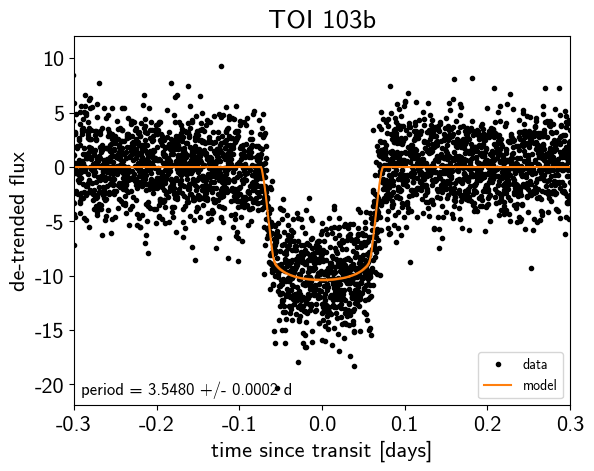

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

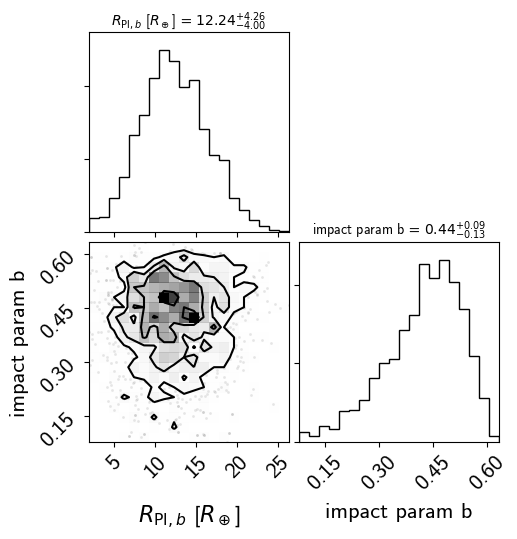

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

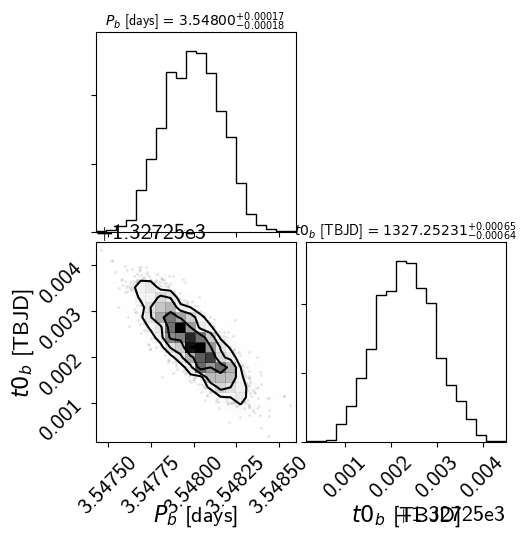

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

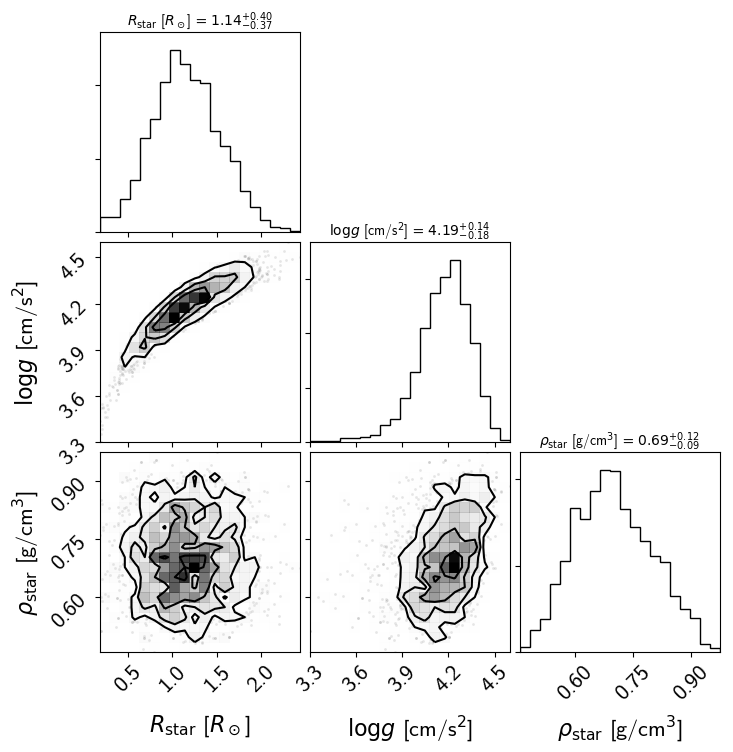

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3